In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
from tensorflow.keras.preprocessing.image import load_img
import os

from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

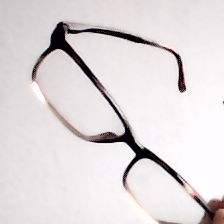

In [2]:
X_test = load_img('testdata/test.png', target_size=(224, 224)) 
X_test

In [3]:
pic = np.array(X_test)
pic.shape

(224, 224, 3)

In [4]:
picc = np.expand_dims(pic,axis=0)
picc.shape

(1, 224, 224, 3)

In [5]:
a = preprocess_input(picc)

In [6]:
VGG16().summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
classes = ['bags', 'cups', 'electric_socket', 'glasses', 'pens', 'phone', 'plants', 'scissor', 'water_container']
base_path = 'datas/'

In [8]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2
    validation_split=0.2
)

In [9]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=32,
        target_size=(224, 224),
    subset='training'
)

Found 710 images belonging to 9 classes.


In [10]:
val_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=32,
        target_size=(224, 224),
    subset='validation'
)

Found 175 images belonging to 9 classes.


In [11]:
train_data_gen.class_indices

{'bags': 0,
 'cups': 1,
 'electric_socket': 2,
 'glasses': 3,
 'pens': 4,
 'phone': 5,
 'plants': 6,
 'scissor': 7,
 'water_container': 8}

In [12]:
classes

['bags',
 'cups',
 'electric_socket',
 'glasses',
 'pens',
 'phone',
 'plants',
 'scissor',
 'water_container']

In [13]:
mobilenet_v2.MobileNetV2().summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Total params: 3,538,984
Trainable params: 3,504,872
Non-trainable params: 34,112
__________________________________________________________________________________________________


In [14]:
base_model = mobilenet_v2.MobileNetV2( 
    pooling='avg',
    weights='imagenet', 
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112
__________________________________________________________________________________________________


In [16]:
# freeze it!
base_model.trainable = False

In [17]:
len(classes)

9

In [18]:
model = keras.Sequential()
model.add(base_model)
#model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 2,386,993
Trainable params: 129,009
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

training =model.fit(train_data_gen,
          verbose=2, 
          callbacks=[callback],
          epochs=10,
          # use 30% of the data for validation
          validation_data=val_data_gen)

Epoch 1/10
23/23 - 34s - loss: 0.5993 - categorical_accuracy: 0.8338 - val_loss: 0.0751 - val_categorical_accuracy: 0.9943
Epoch 2/10
23/23 - 18s - loss: 0.0323 - categorical_accuracy: 0.9958 - val_loss: 0.0476 - val_categorical_accuracy: 0.9943
Epoch 3/10
23/23 - 20s - loss: 0.0057 - categorical_accuracy: 1.0000 - val_loss: 0.0371 - val_categorical_accuracy: 0.9943
Epoch 4/10
23/23 - 17s - loss: 0.0081 - categorical_accuracy: 0.9986 - val_loss: 0.0402 - val_categorical_accuracy: 0.9943
Epoch 5/10
23/23 - 16s - loss: 0.0040 - categorical_accuracy: 1.0000 - val_loss: 0.0409 - val_categorical_accuracy: 0.9943
Epoch 6/10
23/23 - 16s - loss: 0.0038 - categorical_accuracy: 1.0000 - val_loss: 0.0271 - val_categorical_accuracy: 1.0000
Epoch 7/10
23/23 - 16s - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.0276 - val_categorical_accuracy: 1.0000
Epoch 8/10
23/23 - 16s - loss: 0.0018 - categorical_accuracy: 1.0000 - val_loss: 0.0286 - val_categorical_accuracy: 1.0000
Epoch 9/10
23/23

In [20]:
pred = model.predict(a)
pred

array([[1.45592925e-03, 1.23891549e-03, 3.37216276e-04, 9.95989978e-01,
        1.47963263e-04, 1.69464300e-04, 1.14851995e-04, 5.42538182e-04,
        3.22421079e-06]], dtype=float32)

In [21]:
x = pred.argmax(axis = -1)

In [22]:
train_data_gen.class_indices

{'bags': 0,
 'cups': 1,
 'electric_socket': 2,
 'glasses': 3,
 'pens': 4,
 'phone': 5,
 'plants': 6,
 'scissor': 7,
 'water_container': 8}

In [23]:
idx_to_cls = {v: k for k, v in train_data_gen.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(x)
preds_cls

array(['glasses'], dtype='<U7')

<AxesSubplot:>

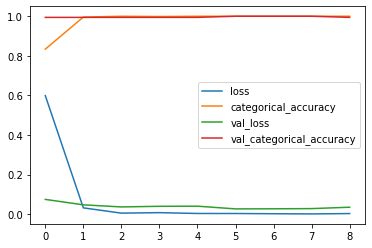

In [24]:
import pandas as pd 
logs = pd.DataFrame(training.history)
logs.plot()